In [1]:
import gym
import math
import random
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('Pong-v0').unwrapped

# set up matplotlib to open viewing window
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
env.observation_space.shape

(210, 160, 3)

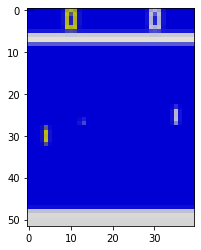

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    # convert to channel,h,w dimensions
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # erase background
    screen[screen == 72] = 0 
    screen[screen == 74] = 0 
    screen[screen == 144] = 0 
    screen[screen != 0] = 213
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    screen = torch.from_numpy(screen)
    
    # convert to batch,channel,h,w dimensions
    return resize(screen).unsqueeze(0).to(device)

env.reset()
# run game for a bit to load the ball and opponent paddle
for i in range(50):
    env.step(0)
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.show()

In [4]:
get_screen().shape

torch.Size([1, 3, 52, 40])

In [7]:
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32

In [8]:
"""
store previous sequence-action pairs to decorrelate temporal locality
transitions are composed of state, action, reward, next_state, and done_mask
"""
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
        
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
            
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

In [9]:
_, _, h, w = get_screen().shape

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
    # action is either random or max probability estimated by Qnet
    def sample_action(self, obs, epsilon):
        out = self.forward(obs) # don't need if random action 
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()

In [10]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)
        
        q_out = q(s)
        # collect output from the chosen action dimension
        q_a = q_out.gather(1,a) 
        
        # most reward we get in next state s_prime
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        # how much is our policy different from the true target 
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
def main():
    env = gym.make('Pong-v0')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()
    
    print_interval = 20
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    
    for episode in range(10):
        # anneal 8% to 1% over training
        epsilon = max(0.01, 0.08 - 0.01*(episode/200))
        env.reset()
        current_s = get_screen()
        done = False
        last_s = get_screen()
        current_s = get_screen()
        s = last_s - current_s
        
        while not done:
            
            
            a = q.sample_action(s, epsilon)
            # first variable would be s_prime but we have get_screen
            _, r, done, info = env.step(a)
            last_s = current_s
            current_s = get_screen()
            s_prime = last_s - current_s
            
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.,s_prime,done_mask))
            s = s_prime
            
            score += r
            if done:
                break
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)
        
        if episode%print_interval==0 and episode!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                episode, score/print_interval, memory.size(), epsilon*100))

In [12]:
get_screen().shape

torch.Size([1, 3, 52, 40])

In [13]:
main()

ValueError: only one element tensors can be converted to Python scalars